In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import statsmodels.formula.api as smf
import statsmodels.api as sm

import xgboost as xgb
from xgboost import XGBRegressor

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [2]:
train_ = pd.read_csv('dataset/train.csv')
test_ = pd.read_csv('dataset/test.csv')

train_.head()

,id,Store,Date,Temperature,Fuel_Price,Promotion1,Promotion2,Promotion3,Promotion4,Promotion5,Unemployment,IsHoliday,Weekly_Sales
0,1,1,05/02/2010,42.31,2.572,NaN,NaN,NaN,NaN,NaN,8.106,False,1643690.90
1,2,1,12/02/2010,38.51,2.548,NaN,NaN,NaN,NaN,NaN,8.106,True,1641957.44
2,3,1,19/02/2010,39.93,2.514,NaN,NaN,NaN,NaN,NaN,8.106,False,1611968.17
3,4,1,26/02/2010,46.63,2.561,NaN,NaN,NaN,NaN,NaN,8.106,False,1409727.59
4,5,1,05/03/2010,46.50,2.625,NaN,NaN,NaN,NaN,NaN,8.106,False,1554806.68


In [3]:
# 편한 가독성을 위해 연, 월, 일을 분리

def split_date(df):
    y = []
    m = []
    d = []
    
    for i in df['Date']:
        d_, m_, y_ = i.split('/')
        y.append(int(y_))
        m.append(int(m_))
        d.append(int(d_))
        
    df.insert(3, 'Y', y)
    df.insert(4, 'M', m)
    df.insert(5, 'D', d)
    
    return df

# holiday이면 1, 아니면 0

def holiday(df):
    tmp = []
    
    for i in df['IsHoliday']:
        if i == False:
            tmp.append(0)
        else:
            tmp.append(1)
            
    df.insert(15, 'Holiday', tmp)
    
    return df

In [4]:
train_ = split_date(train_)
train_ = holiday(train_)

train_ = train_.fillna(0)

test_ = split_date(test_)
test_ = holiday(test_)

test_ = test_.fillna(0)

train_.head()

,id,Store,Date,Y,M,D,Temperature,Fuel_Price,Promotion1,Promotion2,Promotion3,Promotion4,Promotion5,Unemployment,IsHoliday,Holiday,Weekly_Sales
0,1,1,05/02/2010,2010,2,5,42.31,2.572,0.0,0.0,0.0,0.0,0.0,8.106,False,0,1643690.90
1,2,1,12/02/2010,2010,2,12,38.51,2.548,0.0,0.0,0.0,0.0,0.0,8.106,True,1,1641957.44
2,3,1,19/02/2010,2010,2,19,39.93,2.514,0.0,0.0,0.0,0.0,0.0,8.106,False,0,1611968.17
3,4,1,26/02/2010,2010,2,26,46.63,2.561,0.0,0.0,0.0,0.0,0.0,8.106,False,0,1409727.59
4,5,1,05/03/2010,2010,3,5,46.50,2.625,0.0,0.0,0.0,0.0,0.0,8.106,False,0,1554806.68


In [5]:
test_.head()

,id,Store,Date,Y,M,D,Temperature,Fuel_Price,Promotion1,Promotion2,Promotion3,Promotion4,Promotion5,Unemployment,IsHoliday,Holiday
0,1,1,05/10/2012,2012,10,5,68.55,3.617,8077.89,0.00,18.22,3617.43,3626.14,6.573,False,0
1,2,1,12/10/2012,2012,10,12,62.99,3.601,2086.18,0.00,8.11,602.36,5926.45,6.573,False,0
2,3,1,19/10/2012,2012,10,19,67.97,3.594,950.33,0.00,4.93,80.25,2312.85,6.573,False,0
3,4,1,26/10/2012,2012,10,26,69.16,3.506,2585.85,31.75,6.00,1057.16,1305.01,6.573,False,0
4,5,2,05/10/2012,2012,10,5,70.27,3.617,6037.76,0.00,10.04,3027.37,3853.40,6.170,False,0


* XGBoost와 Standard Scaling이 성능이 제일 좋았음
* 추가적인 전처리 과정을 통해 정확도를 높일 계획

1. 의미가 없는 행이 있을 수 있음(Unemployment??)
2. 월(M)과 일(D)를 합쳐서 새로운 변수를 만드는 것이 좋을 수 있음(2월 3일이라 하면 35일로 치환)

In [12]:
def only_date(df):
    # day of year
    doy = []
    
    for i in zip(df['Y'], df['M'], df['D']):
        period = pd.Period("{}-{}-{}".format(i[0], i[1], i[2]))
        doy.append(period.day_of_year)
        
    df.insert(6, 'DOY', doy)
        
    return df

In [13]:
train_ = only_date(train_)
test_ = only_date(test_)

train_.head()

,id,Store,Date,Y,M,D,DOY,Temperature,Fuel_Price,Promotion1,Promotion2,Promotion3,Promotion4,Promotion5,Unemployment,IsHoliday,Holiday,Weekly_Sales
0,1,1,05/02/2010,2010,2,5,36,42.31,2.572,0.0,0.0,0.0,0.0,0.0,8.106,False,0,1643690.90
1,2,1,12/02/2010,2010,2,12,43,38.51,2.548,0.0,0.0,0.0,0.0,0.0,8.106,True,1,1641957.44
2,3,1,19/02/2010,2010,2,19,50,39.93,2.514,0.0,0.0,0.0,0.0,0.0,8.106,False,0,1611968.17
3,4,1,26/02/2010,2010,2,26,57,46.63,2.561,0.0,0.0,0.0,0.0,0.0,8.106,False,0,1409727.59
4,5,1,05/03/2010,2010,3,5,64,46.50,2.625,0.0,0.0,0.0,0.0,0.0,8.106,False,0,1554806.68


In [14]:
test_.head()

,id,Store,Date,Y,M,D,DOY,Temperature,Fuel_Price,Promotion1,Promotion2,Promotion3,Promotion4,Promotion5,Unemployment,IsHoliday,Holiday
0,1,1,05/10/2012,2012,10,5,279,68.55,3.617,8077.89,0.00,18.22,3617.43,3626.14,6.573,False,0
1,2,1,12/10/2012,2012,10,12,286,62.99,3.601,2086.18,0.00,8.11,602.36,5926.45,6.573,False,0
2,3,1,19/10/2012,2012,10,19,293,67.97,3.594,950.33,0.00,4.93,80.25,2312.85,6.573,False,0
3,4,1,26/10/2012,2012,10,26,300,69.16,3.506,2585.85,31.75,6.00,1057.16,1305.01,6.573,False,0
4,5,2,05/10/2012,2012,10,5,279,70.27,3.617,6037.76,0.00,10.04,3027.37,3853.40,6.170,False,0


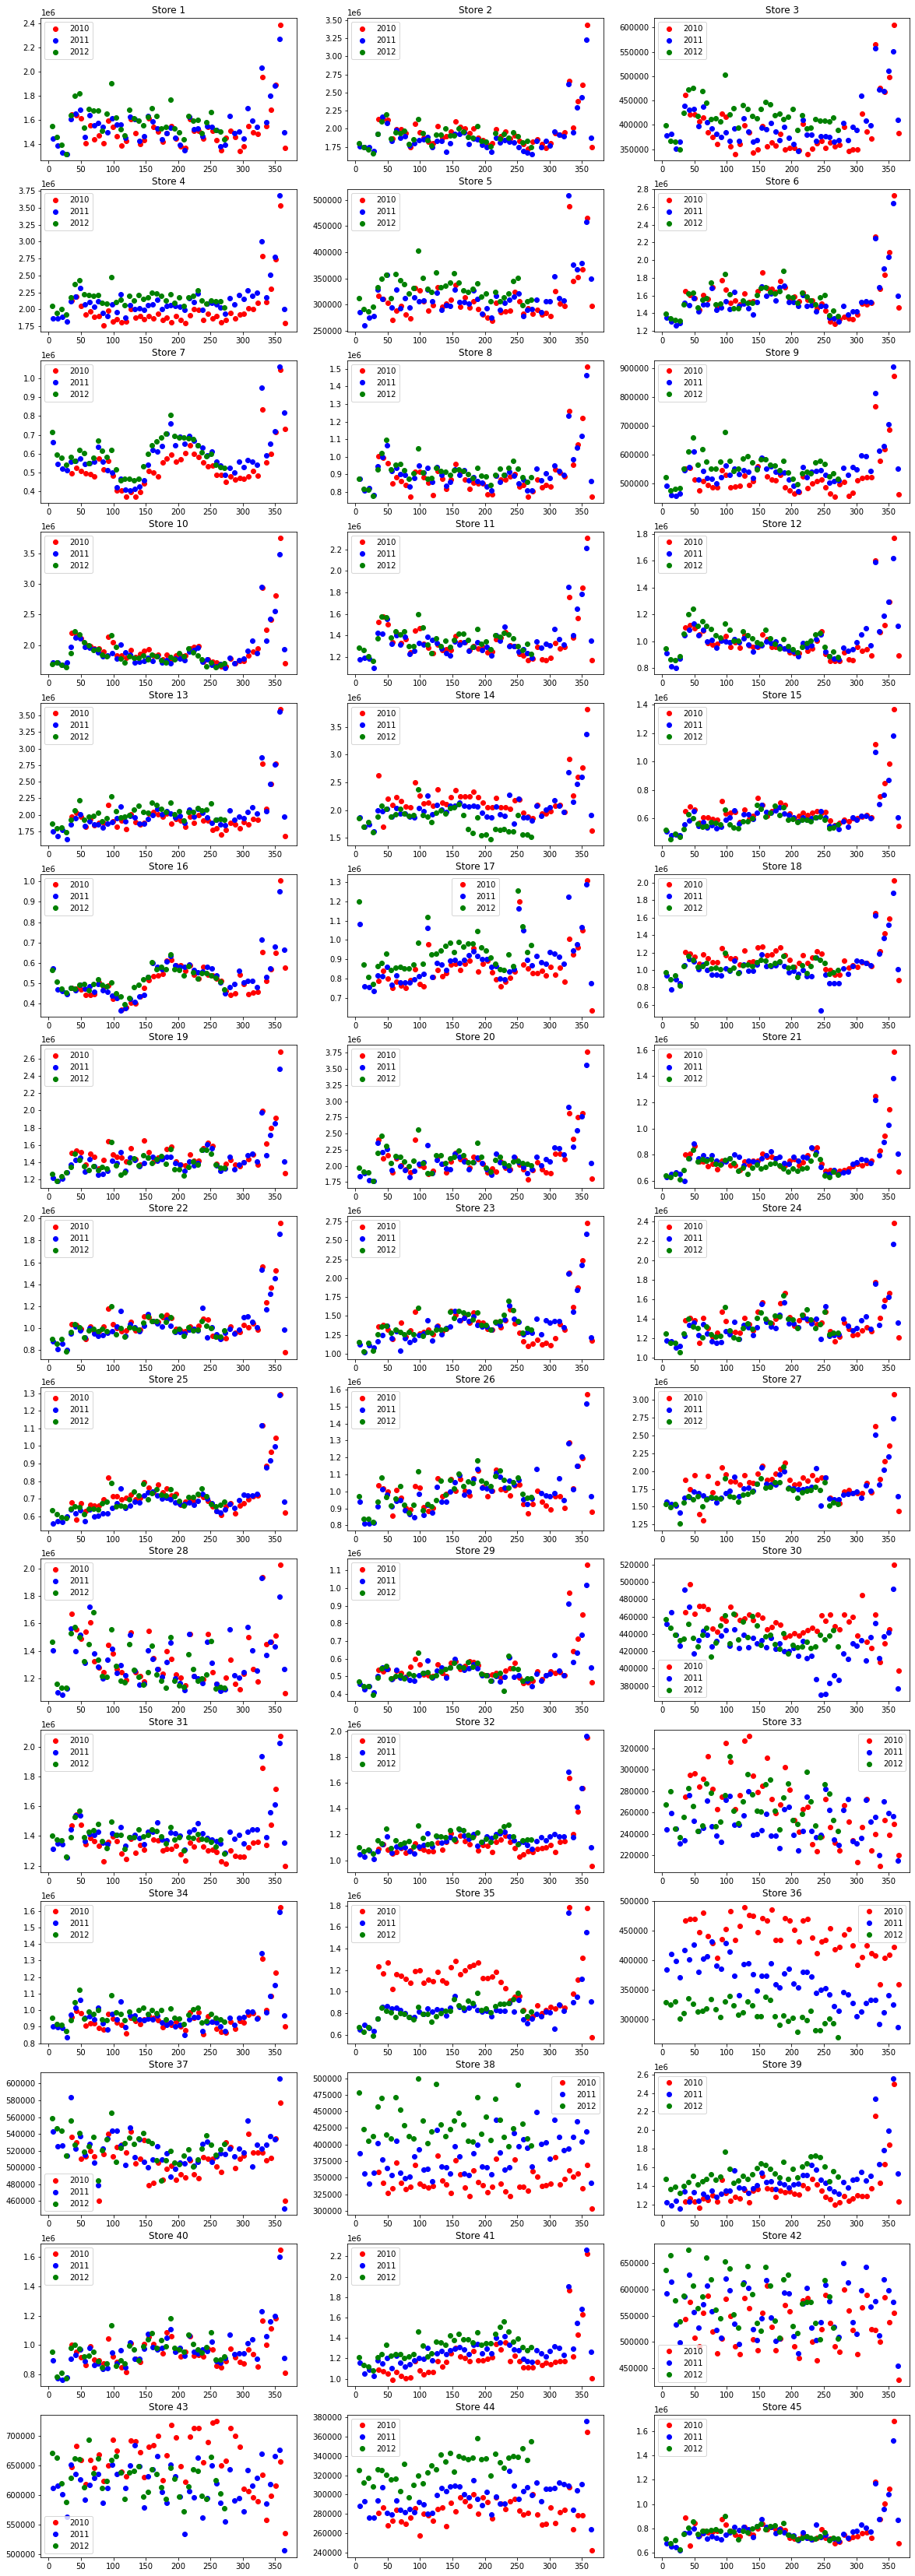

In [29]:
fig = plt.figure(figsize = (20, 60))

for id_ in range(1, 46):
    ax = fig.add_subplot(15, 3, id_)
    store_10 = train_[(train_['Store'] == id_) & (train_['Y'] == 2010)]
    store_11 = train_[(train_['Store'] == id_) & (train_['Y'] == 2011)]
    store_12 = train_[(train_['Store'] == id_) & (train_['Y'] == 2012)]
    
    plt.title('Store {}'.format(id_))
    ax.plot(store_10['DOY'], store_10['Weekly_Sales'], 'o', label = '2010', color = 'red')
    ax.plot(store_11['DOY'], store_11['Weekly_Sales'], 'o', label = '2011', color = 'blue')
    ax.plot(store_12['DOY'], store_12['Weekly_Sales'], 'o', label = '2012', color = 'green')
    ax.legend(loc = 'best')
    
plt.show()

* 지점마다 매출의 분포가 상이한 것을 확인
* 따라서, 분석 또한 지점을 나눠서 분석해야 할 필요가 있음
* 년도에 따라서도 매출이 달라지는 것을 확인할 수 있어, 년도도 분석에 필요한 요소임

+ **지점별 데이터를 살펴볼 때, 데이터의 분포가 어느정도 고른 지점과 넓게 분포된 지점이 나뉨**

+ **엑셀 데이터를 확인해 볼 때, Promotion 2, 3, 4에서 결측치가 다수 존재하는 경우 데이터의 분포가 넓게 분포되는 것을 확인할 수 있음**

+ **이를 검증**

In [42]:
l1 = []
l2 = []

for id_ in range(1, 46):
    store_ = train_[(train_['Store'] == id_) & (train_['Promotion1'] != 0.0)]
    
    # 나누는 기준 : Promotion 2, 3, 4에서 1/3 이상이 결측치인 경우
    count = (store_['Promotion2'] != 0.0).sum() + (store_['Promotion3'] != 0.0).sum() + (store_['Promotion4'] != 0.0).sum()
    if count >= len(store_) * 2:
        l1.append(id_)
    else:
        l2.append(id_)
        
print(l1)
print(l2)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 31, 32, 34, 35, 39, 40, 41, 45]
[30, 33, 36, 37, 38, 42, 43, 44]


+ **test data에서도 l2에 포함된 지점들은 Promotion 2와 4가 결여되어 있는 것을 확인**

+ **지점별로 따로 분석을 진행함과 동시에 l2에 포함된 지점은 Promotion 2, 4를 제거하고 분석 진행**